In [1]:
import os
import sys

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter

from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.dummy import DummyClassifier
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, confusion_matrix, classification_report, roc_auc_score, plot_confusion_matrix, plot_roc_curve, plot_precision_recall_curve
from xgboost import XGBClassifier

module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
from src.algorithm_eval import algorithm_eval_classification
from src.feature_importance_plot import feature_importance_plot
from src.learning_curve_plot import learning_curve_plot
from src.identify_missing_data import identify_missing_data

import warnings
warnings.filterwarnings('ignore')

# Resource: https://www.justintodata.com/logistic-regression-example-in-python/


### Read and Explore the Data

In [2]:
# read the data

df = pd.read_csv('../data/heart_attack_data.csv')

# preview the data

df.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,28,1,2,130.0,132.0,0.0,2.0,185.0,0.0,0.0,NaN,NaN,NaN,0
1,29,1,2,120.0,243.0,0.0,0.0,160.0,0.0,0.0,NaN,NaN,NaN,0
2,29,1,2,140.0,NaN,0.0,0.0,170.0,0.0,0.0,NaN,NaN,NaN,0
3,30,0,1,170.0,237.0,0.0,1.0,170.0,0.0,0.0,NaN,NaN,6.0,0
4,31,0,2,100.0,219.0,0.0,1.0,150.0,0.0,0.0,NaN,NaN,NaN,0


In [3]:
# check the shape of the data

df.shape

# we have 294 rows of data, and 14 potential features.

(294, 14)

In [4]:
# check the summary information of the data
# do we have any categorical data that needs processing?

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294 entries, 0 to 293
Data columns (total 14 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       294 non-null    int64  
 1   sex       294 non-null    int64  
 2   cp        294 non-null    int64  
 3   trestbps  293 non-null    float64
 4   chol      271 non-null    float64
 5   fbs       286 non-null    float64
 6   restecg   293 non-null    float64
 7   thalach   293 non-null    float64
 8   exang     293 non-null    float64
 9   oldpeak   294 non-null    float64
 10  slope     104 non-null    float64
 11  ca        3 non-null      float64
 12  thal      28 non-null     float64
 13  target    294 non-null    int64  
dtypes: float64(10), int64(4)
memory usage: 32.3 KB


In [5]:
# check the distribution of the target

df.target.value_counts(dropna = True, normalize = True)

# The data is slightly imbalanced, with only 12% of users having churned - will oversample the data

0    0.639456
1    0.360544
Name: target, dtype: float64

In [6]:
df.target.value_counts(normalize = True)

0    0.639456
1    0.360544
Name: target, dtype: float64

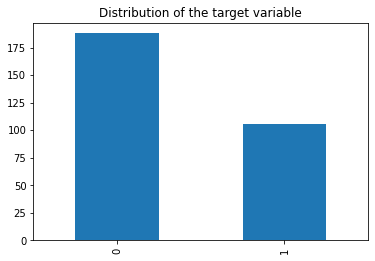

In [7]:
# visualise the distribution of the target

df.target.value_counts(dropna = True).plot(kind = 'bar')
plt.title("Distribution of the target variable");

# question: does the distribution look equal to you? 
# example of an imbalanced dataset

### Handle Missing Data

In [8]:
missing_value_df = identify_missing_data(df)
missing_value_df

,feature,percent_missing,data_type
0,ca,98.98,float64
1,thal,90.48,float64
2,slope,64.63,float64
3,chol,7.82,float64
4,fbs,2.72,float64
5,trestbps,0.34,float64
6,restecg,0.34,float64
7,thalach,0.34,float64
8,exang,0.34,float64
9,age,0.00,int64


In [9]:
# drop features which have more than 40% missing values
# identify features which have more than 40% missing data

threshold = 0.4

cols_to_drop = list(missing_value_df[missing_value_df.percent_missing > threshold].feature)
print("number of columns to drop:", len(cols_to_drop))
print(cols_to_drop)

number of columns to drop: 5
['ca', 'thal', 'slope', 'chol', 'fbs']


In [10]:
df.drop(cols_to_drop, axis = 1, inplace = True)

In [11]:
# check the columns were dropped

missing_value_df = identify_missing_data(df)
missing_value_df

,feature,percent_missing,data_type
0,trestbps,0.34,float64
1,restecg,0.34,float64
2,thalach,0.34,float64
3,exang,0.34,float64
4,age,0.00,int64
5,sex,0.00,int64
6,cp,0.00,int64
7,oldpeak,0.00,float64
8,target,0.00,int64


In [12]:
# fill the remaining features with missing values with 0

df.chol.fillna(0, inplace = True)
df.fbs.fillna(0, inplace = True)
df.trestbps.fillna(0, inplace = True)
df.restecg.fillna(0, inplace = True)
df.exang.fillna(0, inplace = True)
df.thalach.fillna(0, inplace = True)


AttributeError: 'DataFrame' object has no attribute 'chol'

In [ ]:
# check to see if we have any missing values that need handling

missing_value_df = identify_missing_data(df)
missing_value_df

In [ ]:
df.shape

### Split the data into train and test

In [ ]:
# define the target and features

target = df["target"]
features = df.drop(["target"], axis = 1)


In [ ]:
target.shape

In [ ]:
target

In [ ]:
features.shape

In [ ]:
features

In [ ]:
# split the data into train and test set
# because the dataset is imbalanced we can use stratify

X_train, X_test, y_train, y_test = train_test_split(
                                                features, 
                                                target,
                                                test_size = 0.2, 
                                                random_state = 8888)



In [ ]:
# print the shape of the training data

print("Training Data")
print("Shape of X_train", X_train.shape)
print("Shape of y_train", y_train.shape)
print("Distribution of target:", Counter(y_train))

In [ ]:
# print the shape of the test data 

print("Test Data")
print("Shape of X_test", X_test.shape)
print("Shape of y_test", y_test.shape)
print("Distribution of target:", Counter(y_test))

In [ ]:
X_train.head()

### Model Selection

In [ ]:
# model selection
# list of models we want to evaluate

models = []

# using Dummy Classifier as a baseline algorithm
models.append(('Dummy Classifier', DummyClassifier(strategy = 'stratified')))

# Decision Tree
models.append(('Decision Tree', DecisionTreeClassifier()))

# Random Forest model
models.append(('Random Forest', RandomForestClassifier()))

# XGBoost
models.append(('XGBoost', XGBClassifier(eval_metric='logloss')))

In [ ]:
# training every model on random samples of data (cross validation)

scoring_df = []

# scoring df for models with no sampling techniques
print("Model results using no sampling techniques")

scoring_results = algorithm_eval(models, X_train, y_train)

# look at the boxplots - which one has the largest variance in predictions? 
# these are examples of high variance = overfitted models

In [ ]:
scoring_df = pd.DataFrame(scoring_results)
scoring_df.sort_values(by = 'Accuracy Mean', ascending = False)

### Evaluating the "Best Model" in detail

In [ ]:
# the best model is between Random Forest and XGBoost
# XGBoost showing signs of less overfitting, but Random Forest has the highest average f1 score and recall 
# let's look at the best model in more detail

best_model = RandomForestClassifier()
best_model.fit(X_train, y_train)
y_pred = best_model.predict(X_test)
print(Counter(y_pred))

In [ ]:
print("first five predicted values:", y_pred[0:5])
print("first five actual values:", list(y_test[0:5]))

In [ ]:
# evaluation metrics

print("accuracy:", round(accuracy_score(y_test, y_pred), 2))
print("recall:", round(recall_score(y_test, y_pred), 2))
print("precision:", round(precision_score(y_test, y_pred), 2))
print("f1-score:", round(f1_score(y_test, y_pred), 2))

In [ ]:
print(classification_report(y_pred, y_test))

In [ ]:
plot_confusion_matrix(best_model, 
                      X_test, 
                      y_test,
                      cmap = plt.cm.Blues);

In [ ]:
# handy sklearn function to plot Receiver operating characteristic (ROC) curve, with the area under the curve.

plot_roc_curve(best_model,
               X_test, 
               y_test);                    

# AUC of 0.89; the higher the AUC, the better the performance of the model at distinguishing between the positive and negative classes.

### Feature Importance Plot

In [ ]:
feature_importance_plot(best_model, X_train, n = 5)

# question: what is the most important feature?

### Learning Curve

In [ ]:
learning_curve_plot(best_model, X_train, y_train, scoring = 'accuracy')

# what does this plot mean? we will learn more about this in IP301. 
# However, very simply WE NEED MORE DATA!

In [ ]:
# TASKS: 
# 1. Can you build an XGBoost Classification Model?
# 2. Can you evaluate the XGBoost Model?
# 3. Can you plot a feature important plot for the XGBoost Model?
# 4. Can you plot a learning curve for the XGBoost Model?

In [ ]:
# Build the model

xgb = XGBClassifier(eval_metric='logloss')
xgb.fit(X_train, y_train)
y_pred_xgb = xgb.predict(X_test)
print(Counter(y_pred_xgb))

In [ ]:
# evaluation metrics

print("accuracy:", round(accuracy_score(y_test, y_pred_xgb), 2))
print("recall:", round(recall_score(y_test, y_pred_xgb), 2))
print("precision:", round(precision_score(y_test, y_pred_xgb), 2))
print("f1-score:", round(f1_score(y_test, y_pred_xgb), 2))

In [ ]:
print("first five predicted values:", y_pred_xgb[0:5])
print("first five actual values:", list(y_test[0:5]))

In [ ]:
plot_confusion_matrix(xgb, 
                      X_test, 
                      y_test,
                      cmap = plt.cm.Blues);

In [ ]:
plot_roc_curve(xgb,
               X_test, 
               y_test);  

In [ ]:
# Feature Importance for the XGBClassifier

feature_importance_plot(xgb, X_train, n = 5)

# question: what is the most important feature?

In [ ]:
# Learning curve for the XGBClassifier

learning_curve_plot(xgb, X_train, y_train, scoring = 'accuracy')

In [ ]:
# The new housing price data, for the next model

from sklearn.datasets import fetch_openml
housing = fetch_openml(name="house_prices", as_frame=True)  

housing_df = pd.DataFrame(housing['data'], columns=housing['feature_names'])
housing_df['target'] = housing['target']
housing_df.drop(['Id'], inplace = True, axis = 1)

housing_df.head()